In [50]:
%matplotlib inline

In [82]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display
import numpy as np
import math

In [116]:
class Body(plt.Circle):

    G = 2
    def __init__(self, x,y,mass,radius = 0.2,color='green'):
        self.x = x
        self.y = y
        self.mass = mass
        self.body = plt.Circle((self.x,self.y), radius = radius,color = color)
        self.velocity = np.array([0,0])
    
    @staticmethod
    def calc_acceleration(m,r):
        return Body.G * m/r**2

    @staticmethod
    def distance(point1,point2):
        return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)
    
    
circleA = Body(1,1,200)
circleA.velocity = np.array([0.03,0.03])
circleB = Body(3,3, 5, radius= 0.08,color='red')
circleB.velocity = np.array([0.01,0.01])

print(f'Acceleration: {circleA.calc_acceleration(200, 10)}')

fig = plt.figure(figsize= (5,5))
ax = fig.add_subplot(111)
ax.add_artist(circleA.body)
ax.add_artist(circleB.body)

lines = plt.plot([])
line = lines[0]


plt.xlim(0,10)
plt.ylim(0,10)

def animate(frame):
    dist = circleA.distance([circleA.x, circleA.y], [circleB.x, circleB.y])
    acceleration = circleA.calc_acceleration(circleA.mass, dist)
    print(dist, acceleration)
    circleA.x+=circleA.velocity[0]
    circleA.y = circleA.x ** 2
    circleB.x += 0.02
    circleB.y += 0.02
    circleA.body.center = (circleA.x, circleA.y)
    circleB.body.center = (circleB.x, circleB.y)
    line.set_data((circleA.x,circleA.y))
    line.set_data((circleB.x, circleB.y))
    
    
anim = FuncAnimation(fig, animate,frames=200, interval=20)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

Acceleration: 4.0
2.8284271247461903 49.999999999999986
2.792520870110016 51.294067180334764
2.7555378712694187 52.68017668762685
2.7175190174127577 54.164508589022525
2.6785099141126953 55.7536718922279
2.638561397807525 57.454702802083816
2.597730116852018 59.275050483967746
2.556079186958025 61.22254557402851
2.513678929378213 63.305345280520676
2.4706077005465676 65.53184719085313
2.42695282195596 67.91056179012243
2.382811618655574 70.44993118019221
2.338292573652835 73.15807857154229
2.293516603384418 76.04246987911671
2.2486184558523923 79.10946538108094
2.203748227452491 82.36373627646424
2.159072986260538 85.8075187705664
2.1147784777607317 89.43967810337872
2.0710708727612386 93.25455834809027
2.028178495596479 97.2406031609989
1.986353442869621 101.37875101378759
1.9458729686184546 105.64063942155673
1.9070404715160076 109.98669996829312
1.8701858757888206 114.3642920302376
1.835665154651032 118.7061072297908
1.8038587112077258 122.92917166866756
1.7751683187799396 126.93486

1.4142135623730951
[2 2]
[3 1]
[-1  1]


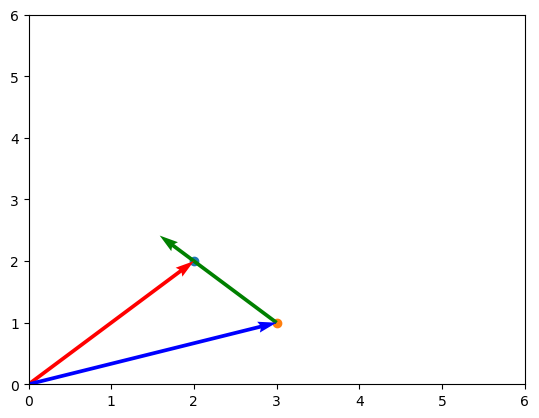

In [110]:
def calc_distance(v1,v2):
    return math.sqrt((v1[0] - v2[0]) **2 + (v1[1] - v2[1])**2)

A = np.array([2,2])
B = np.array([3,1])
d = circleA.distance(A,B)
print(d)
print(A)
print(B)
print(A+(-1)* B)
plt.xlim(0,6)
plt.ylim(0,6)
plt.scatter(2,2)
plt.scatter(3,1)
plt.quiver(3,1,-1 * d,1 *d, angles = "xy", scale_units = "xy", scale = 1, color = 'green')
plt.quiver(0,0,2,2, angles = "xy", scale_units = "xy", scale = 1, color = 'red')
plt.quiver(0,0,3,1, angles = "xy", scale_units = "xy", scale = 1, color = 'blue')

plt.show()


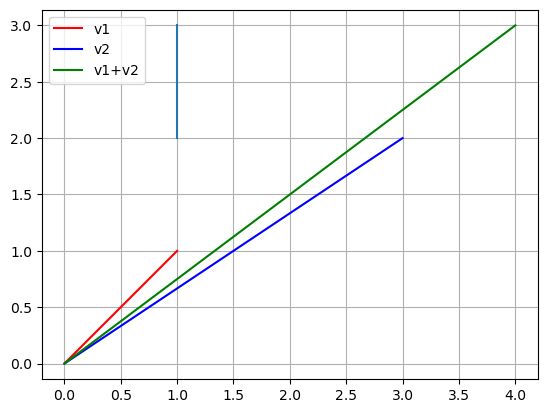

In [80]:
# Векторите
v1 = np.array([1, 1])
v2 = np.array([3, 2])

# Изчисляване на сумата
v_sum = v1 + v2

# Начертаване на графиката
plt.figure()
plt.plot([0, v1[0]], [0, v1[1]], '-r', label='v1') # Червената линия е v1
plt.plot([0, v2[0]], [0, v2[1]], '-b', label='v2') # Синята линия е v2
plt.plot([0, v_sum[0]], [0, v_sum[1]], '-g', label='v1+v2') # Зелената линия е v1+v2
plt.plot([1,1], [3,2])
plt.legend(loc='upper left')
plt.axis('equal')
plt.grid()
plt.show()